In [1]:
# There is a pytorch edition of GAN
# Version: 1.0
# Date: 2017-07-21
# Place: BIBDR DeepLearning Lab
# Author: Jiahao Yao
# Acknowledage: Shenjian Zhao
# Please use the Python 2 with seaborn, pandas, pytorch
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas
from scipy import stats, integrate
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
sns.set(color_codes = True)
np.random.seed(sum(map(ord, 'distributions')))

mu = 4
sigma = 2

batch_size = 128
data_dim = 1 
mid_dim = 6
sample_dim  = 20

GPU = True

In [2]:
def plot_states(D, G):
    f,ax=plt.subplots(1)
    n = 50
    n_dist = Variable(torch.randn(1000)*sigma+mu)
    n_dist = torch.unsqueeze(n_dist,1)
    u_dist = torch.rand(1000, sample_dim)*sigma*2-sigma
    u_dist = Variable(u_dist)
    if GPU:
        n_dist = n_dist.cuda()
        u_dist = u_dist.cuda()
        
    gn_dist = G(u_dist)
    if GPU:
        sns.kdeplot(np.squeeze(n_dist.data.cpu().numpy()),ax=ax,label = 'p_data')
    #     There might be an error here, because the model does not know how to plot if all number are the same
        sns.kdeplot(np.squeeze(gn_dist.data.cpu().numpy()),ax=ax,label = 'p_g')
    else:
        sns.kdeplot(np.squeeze(n_dist.data.numpy()),ax=ax,label = 'p_data')
        sns.kdeplot(np.squeeze(gn_dist.data.numpy()),ax=ax,label = 'p_g')
    
    plt.ylim(0,0.9)
    dx = []
    xx = []
    for i in np.arange(mu-sigma*4, mu+sigma*4, 0.5):

        tmp_m = 1000
        n_dist = Variable(torch.randn(1000)+i)
        if GPU:
            n_dist = n_dist.cuda()
        n_dist = torch.unsqueeze(n_dist,1)
        D_value = D(n_dist)
        tmp_d = D_value.data.sum()
        dx.append(tmp_d / tmp_m)
        xx.append(i)
    ax.plot(xx, dx, label='d', marker='*')
    plt.legend()
    plt.show()

In [3]:
discriminator = nn.Sequential(
    nn.Linear(data_dim, mid_dim),
    nn.ReLU(),
    nn.Linear(mid_dim,mid_dim),
    nn.ReLU(),
    nn.Linear(mid_dim,1),
    nn.Sigmoid()
)

generator = nn.Sequential(
    nn.Linear(sample_dim, mid_dim),
    nn.ReLU(),
    nn.Linear(mid_dim,mid_dim),
    nn.ReLU(),
    nn.Linear(mid_dim,data_dim),
    nn.ReLU()    
)
if GPU:
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    


In [4]:
def reset_grad():
    for p in generator.parameters():
        p.grad.data.zero_()
    for p in discriminator.parameters():
        p.grad.data.zero_()

G_solver = torch.optim.Adam(generator.parameters(), lr= 1e-4)
D_solver = torch.optim.Adam(discriminator.parameters(), lr= 1e-4)
ones_label = Variable(torch.ones(batch_size))
zeros_label = Variable(torch.zeros(batch_size))
ones_label = torch.unsqueeze(ones_label,1)
zeros_label = torch.unsqueeze(zeros_label,1)
if GPU:
    ones_label = ones_label.cuda()
    zeros_label = zeros_label.cuda()

Iter-0;D_loss:[ 1.49199963];G_loss:[ 0.79933178]


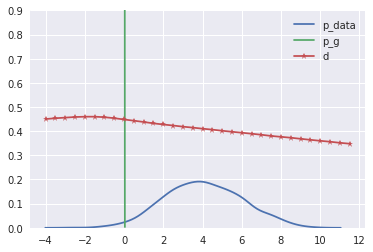

Iter-2000;D_loss:[ 1.19764173];G_loss:[ 0.65059602]


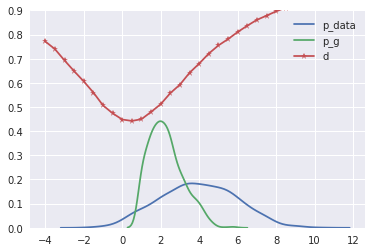

Iter-4000;D_loss:[ 1.37416601];G_loss:[ 0.7786904]


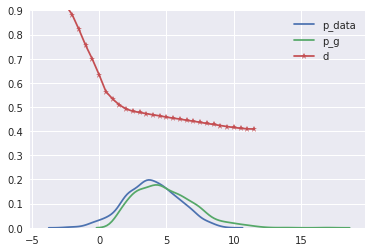

Iter-6000;D_loss:[ 1.38086498];G_loss:[ 0.71804935]


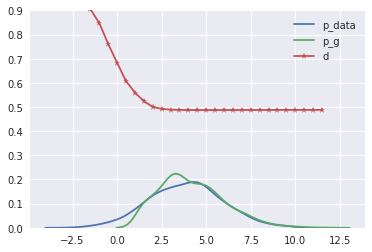

Iter-8000;D_loss:[ 1.36550725];G_loss:[ 0.71106076]


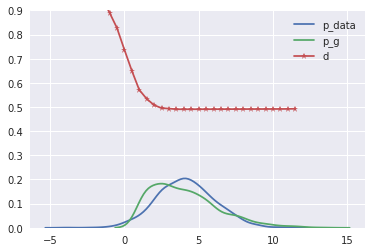

In [5]:
for it in range(10000):
    n_dist = Variable(torch.randn(batch_size)*sigma+mu)
    n_dist = torch.unsqueeze(n_dist,1)
    u_dist = torch.rand(batch_size, sample_dim)*sigma*2-sigma
    u_dist = Variable(u_dist)
    
    if GPU:
        n_dist = n_dist.cuda()
        u_dist = u_dist.cuda()
        
    G_sample = generator(u_dist)
    D_real = discriminator(n_dist)
    D_fake = discriminator(G_sample)
    
    D_loss_real = F.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = F.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward()
    D_solver.step()
    
    reset_grad()
    
    
    u_dist = torch.rand(batch_size, sample_dim)*sigma*2-sigma
    u_dist = Variable(u_dist)
    
    if GPU:
        u_dist = u_dist.cuda()
        
    G_sample = generator(u_dist)
    D_fake = discriminator(G_sample)
    
    G_loss = F.binary_cross_entropy(D_fake, ones_label)
    
    G_loss.backward()
    G_solver.step()
    
    reset_grad()
    
    if it% 2000 == 0:
        if GPU:
            print 'Iter-{};D_loss:{};G_loss:{}'.format(it,D_loss.data.cpu().numpy(),G_loss.data.cpu().numpy())
        else:
            print 'Iter-{};D_loss:{};G_loss:{}'.format(it,D_loss.data.numpy(),G_loss.data.numpy())
        plot_states(discriminator,generator)
    
    
    
    
    